In [1]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

## 1. Collect data from website

In [2]:
# set params
urls = ["https://startlinetiming.com/en/races/2023/rfw_toronto/event/10K",
        "https://startlinetiming.com/en/races/2023/rfw_toronto/event/5K"]

ua = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

In [3]:
def get_data(url):
    response = requests.get(url, headers=ua)
    soup = BeautifulSoup(response.content, "html.parser")

    table = soup.find("table")

    headers = []
    for row in table.find_all("th"):
        headers.append(row.text.strip())

    data = []

    for row in table.find_all("tr"):
        row_data = [cell.text.strip() for cell in row.find_all("td")]
        row_data = [re.sub(r"\n+", lambda match: "\n" if match.start() != 0 else "", l) for l in row_data]
        row_data = [l.replace("\n", "; ") for l in row_data]

        data.append(row_data)

    return headers, data

In [4]:
data = []
headers = []

for url in urls:
    h, d = get_data(url)
    headers.append(h)
    data.append(d)

In [5]:
df10k = pd.DataFrame(data[0], columns=headers[0])
df5k = pd.DataFrame(data[1], columns=headers[1])

In [6]:
df = pd.concat([df10k,df5k])

## 2. Clean and prep data

In [7]:
# get location from name
df['Location'] = df['Name'].apply(lambda x: x.split("; ")[1])

# get city from location
df['City'] = df['Location'].apply(lambda x: x.split(',')[0])

In [8]:
# get gender and age from division
df['Gender'] = df['Division'].apply(lambda x: x[0])
df['Age'] = df['Division'].apply(lambda x: x[1:3]+'-'+x[3:])

In [9]:
df.drop(columns=['Name','Location'],inplace=True)

In [10]:
# remove rows w/o age
df = df[df['Age'] != '99-99'].copy()

In [11]:
df.head()

,Event,Place,Gun Time,Race #,Division,Place/Gender,Place/Division,Chip Time,City,Gender,Age
0,10K,1/374,0:39:03,15946,M3039,1/108,1/49,0:39:00,Toronto,M,30-39
1,10K,2/374,0:39:13,16066,F3039,1/263,1/98,0:38:29,Markham,F,30-39
2,10K,3/374,0:39:14,16065,F4049,2/263,1/58,0:38:28,Toronto,F,40-49
3,10K,4/374,0:40:18,16126,M3039,2/108,2/49,0:40:15,Toronto,M,30-39
4,10K,5/374,0:40:24,15342,M2029,3/108,1/25,0:40:15,North York,M,20-29


## 3. Explore and find insights

In [12]:
sns.set()
%matplotlib inline

### The 10K skewed younger than the 5K

array([<Axes: title={'center': '10K'}>, <Axes: title={'center': '5K'}>],
      dtype=object)

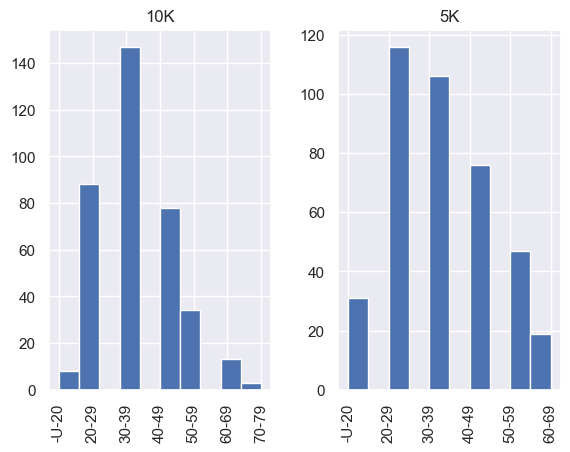

In [13]:
df.sort_values(by='Age').hist(column='Age', by='Event')

### There was a similar distribution of males and females in each race

In [14]:
df.groupby(['Event', 'Gender'])['Gender'].count().transform(lambda x: round(x/x.sum() * 100, 1)).rename\
('perc').reset_index().pivot(index='Event', columns='Gender', values='perc')

Gender,F,M
Event,,
10K,34.3,14.1
5K,35.2,16.3


In [15]:
df['Gun Time_dt'] = pd.to_datetime(df['Gun Time'])

In [16]:
df['Gun Time_m'] = round((df['Gun Time_dt'].dt.hour*3600 + df['Gun Time_dt'].dt.minute*60 + df['Gun Time_dt'].dt.second)/60, 1)


In [17]:
pd.set_option('display.max_rows', 100)

In [18]:
df.head()

,Event,Place,Gun Time,Race #,Division,Place/Gender,Place/Division,Chip Time,City,Gender,Age,Gun Time_dt,Gun Time_m
0,10K,1/374,0:39:03,15946,M3039,1/108,1/49,0:39:00,Toronto,M,30-39,2023-06-11 00:39:03,39.0
1,10K,2/374,0:39:13,16066,F3039,1/263,1/98,0:38:29,Markham,F,30-39,2023-06-11 00:39:13,39.2
2,10K,3/374,0:39:14,16065,F4049,2/263,1/58,0:38:28,Toronto,F,40-49,2023-06-11 00:39:14,39.2
3,10K,4/374,0:40:18,16126,M3039,2/108,2/49,0:40:15,Toronto,M,30-39,2023-06-11 00:40:18,40.3
4,10K,5/374,0:40:24,15342,M2029,3/108,1/25,0:40:15,North York,M,20-29,2023-06-11 00:40:24,40.4


### The 5K was finished in 20 to 40 mins, whereas the 10K took between 40 and 90 mins

<Axes: xlabel='Gun Time_m', ylabel='Count'>

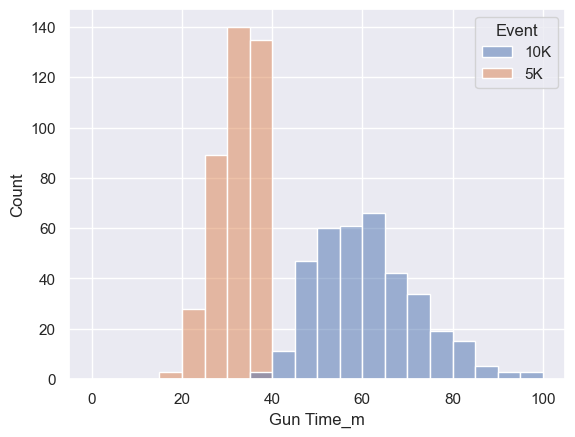

In [19]:
sns.histplot(x='Gun Time_m', data=df, hue='Event', binwidth=5, binrange=[0,100])

### Overall, Male runners finished earlier than female runners in the 5K

### There were two groups of Male and Female runners respectively – those who finished before or after 35 mins

<Axes: xlabel='Gun Time_m', ylabel='Count'>

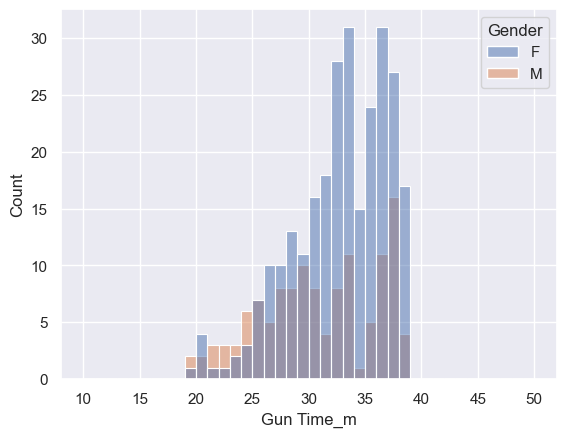

In [20]:
sns.histplot(x='Gun Time_m', data=df[df['Event']=='5K'], hue='Gender', binwidth=1, binrange=[10,50])

### Male runners finished earlier than Female runners in the 10K

### However, there were plenty of outliers, with more female runners finishing before male runners for the earliest times (< 45 mins)

<Axes: xlabel='Gun Time_m', ylabel='Count'>

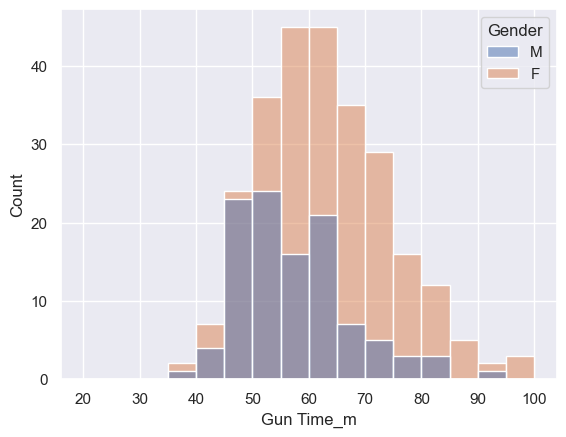

In [21]:
sns.histplot(x='Gun Time_m', data=df[df['Event']=='10K'], hue='Gender', binwidth=5, binrange=[20,100])

In [22]:
gender_gap_o = df.groupby(['Event','Age','Gender'])['Gun Time_m'].mean().round(1).reset_index()

In [23]:
gender_gap_o.sort_values(by=['Event','Age'],inplace=True)

In [24]:
# drop 70-79 age group
gender_gap_o.drop(index=[12,13],inplace=True)

### The gender gap in times was the most for the 50-59 (\~3 mins) and 60-69 (~6 mins) age groups in the 5K

### The gender gap in times was the most for the 30-39 (\~6 mins) and 40-49 (~7 mins) age groups in the 10K

In [25]:
df[df['Gender'] == 'F'].groupby(['Event','Age'])['Gun Time_m'].mean().round(1) - df[df['Gender'] == 'M'].groupby(['Event','Age'])['Gun Time_m'].mean().round(1)


Event  Age  
10K    -U-20    -3.0
       20-29     3.8
       30-39     6.3
       40-49     6.7
       50-59     4.7
       60-69    -0.7
       70-79    63.5
5K     -U-20     2.4
       20-29     2.2
       30-39     1.2
       40-49     0.2
       50-59     3.4
       60-69     6.4
Name: Gun Time_m, dtype: float64

In [26]:
df['Chip Time_dt'] = pd.to_datetime(df['Chip Time']) - pd.Timedelta('1 days')

In [27]:
df['adv'] = (df['Gun Time_dt'] - df['Chip Time_dt']).dt.seconds

In [28]:
df['adv_m'] = df['adv']/60

### The mean advantage of going earlier was 2mins for the 5K, suggesting that some runners' times were adversely affected by starting later!

In [29]:
df[df['Event'] == '10K']['adv_m'].describe()

count    371.000000
mean       1.144924
std        2.924843
min        0.000000
25%        0.166667
50%        0.366667
75%        0.616667
max       16.416667
Name: adv_m, dtype: float64

In [30]:
df[df['Event'] == '5K']['adv_m'].describe()

count     395.000000
mean       19.784599
std       160.183391
min         0.000000
25%         0.233333
50%         0.616667
75%         3.225000
max      1439.966667
Name: adv_m, dtype: float64

In [31]:
df[(df['Event'] == '5K') & (df['adv_m'] < 9)].describe().loc[:, 'adv_m']

count    390.000000
mean       1.672009
std        2.123988
min        0.000000
25%        0.233333
50%        0.600000
75%        3.183333
max        7.783333
Name: adv_m, dtype: float64

array([[<Axes: title={'center': 'adv_m'}>]], dtype=object)

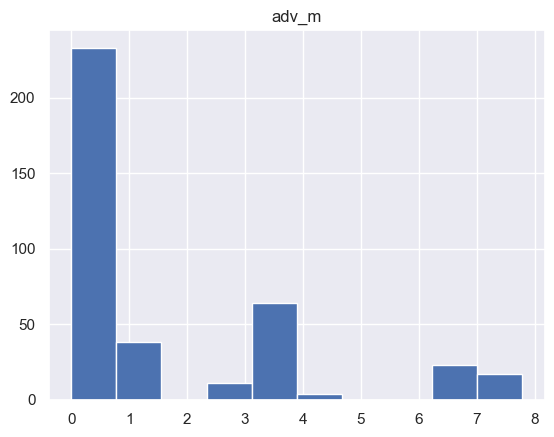

In [32]:
df[(df['Event'] == '5K') & (df['adv_m'] < 9)].hist(column='adv_m')